In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
train_df = pd.read_csv('../data/Titanic/train.csv')
test_df = pd.read_csv('../data/Titanic/test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Data Preparation & Feature Engineering

In [45]:
train_df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [46]:
train_df['Survived'] = train_df['Survived'].astype('category')

In [47]:
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
def convert (df, features):
    for feature in features:
        df[feature] = df[feature].astype('category')

convert(train_df, features)

* Ta sẽ tạo 1 feature mới tên là Title từ Name tương ứng với danh xưng của hành khách trên chuyến tàu (Mr, Mrs, Miss, Countess, Dr,....)

In [48]:
import re # để dùng biểu thức chính quy (regex).
def extract_title(name):
    word = re.compile(r", ([\w\s]+)\.")
    return word.search(name).groups(1)[0].strip()

train_df['Title'] = train_df['Name'].apply(lambda name : extract_title(name))
test_df['Title'] = test_df['Name'].apply(lambda name : extract_title(name))

In [49]:
train_df['Title']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

In [50]:
def group_title(title):
    if title in ['Mr', 'Mrs', 'Miss', 'Master']:
        return title
    elif title == 'Ms':
        return 'Miss'
    else:
        return 'Others'
train_df['Title'] = train_df['Title'].apply(lambda title : group_title(title))
test_df['Title'] = test_df['Title'].apply(lambda title : group_title(title))
train_df['Title'].value_counts()

Title
Mr        517
Miss      183
Mrs       125
Master     40
Others     26
Name: count, dtype: int64

<Axes: xlabel='Title', ylabel='count'>

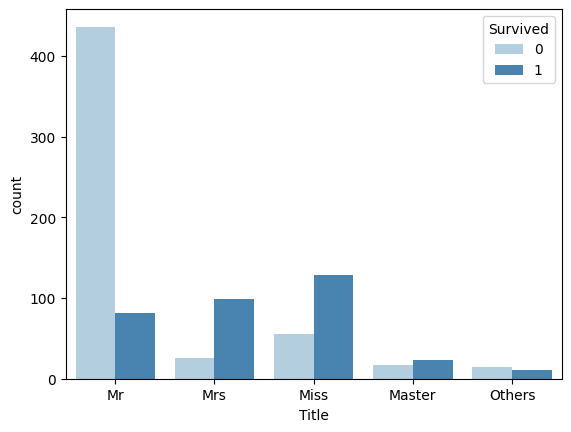

In [51]:
sns.countplot(data = train_df, x = 'Title', hue = 'Survived', palette='Blues')

In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    category
 7   Parch        891 non-null    category
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
 12  Title        891 non-null    object  
dtypes: category(6), float64(2), int64(1), object(4)
memory usage: 55.3+ KB


* TẠO CỘT FAMILY_SIZE VÀ FAMILY_CAT ĐỂ XEM TỈ LỆ SỐNG SÓT CỦA HÀNH KHÁCH ĐI MỘT MÌNH VÀ ĐI CÙNG GIA ĐÌNH KHÁC NHAU NHƯ THẾ NÀO 

In [53]:
train_df['Family'] = train_df['SibSp'].astype('int') + train_df['Parch'].astype('int') + 1
test_df['Family'] = test_df['SibSp'].astype('int') + test_df['Parch'].astype('int') + 1

In [54]:
train_df['Family_Cat'] = pd.cut(train_df['Family'], bins = [0,1,4,6,20], labels = ['Alone', 'SmallFamily', 'MediumFamily', 'LargeFamily'])
test_df['Family_Cat'] = pd.cut(test_df['Family'], bins = [0,1,4,6,20], labels = ['Alone', 'SmallFamily', 'MediumFamily', 'LargeFamily'])

<Axes: xlabel='Family_Cat', ylabel='count'>

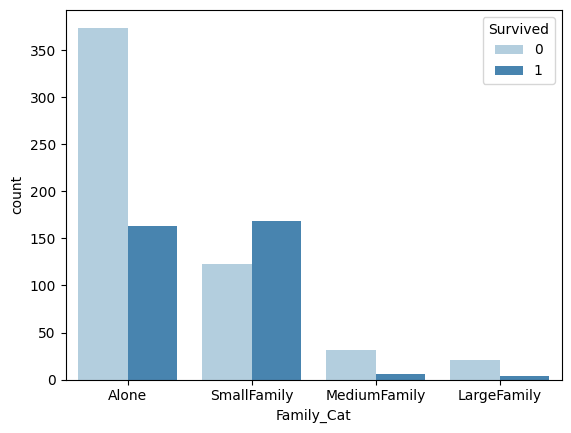

In [55]:
sns.countplot(data = train_df, x = 'Family_Cat', hue = 'Survived', palette='Blues')


In [56]:
num_features = ['Age', 'Fare']
cat_features = ['Sex', 'Pclass', 'Embarked', 'Title', 'Family_Cat']
feature_cols = num_features + cat_features
print(feature_cols)

['Age', 'Fare', 'Sex', 'Pclass', 'Embarked', 'Title', 'Family_Cat']


In [57]:
def display_missing(df, feature_cols):
    n_rows = df.shape[0]
    for col in feature_cols:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"Col {col} has {missing_count*100/n_rows:.2f}% missing values")


display_missing(train_df, feature_cols)
display_missing(test_df, feature_cols)

Col Age has 19.87% missing values
Col Embarked has 0.22% missing values
Col Age has 20.57% missing values
Col Fare has 0.24% missing values


FILLING MISSING VALUE

In [58]:
age_by_sex_pclass = train_df.groupby(['Sex', 'Pclass'], observed=False)['Age'].median()
age_by_sex_pclass

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [59]:
train_df['Age'] = train_df.groupby(['Sex', 'Pclass'], observed=False)['Age'].transform(lambda x: x.fillna(x.median()))
test_df['Age'] = test_df.groupby(['Sex', 'Pclass'], observed=False)['Age'].transform(lambda x: x.fillna(x.median()))


In [60]:
display_missing(train_df, feature_cols)
display_missing(test_df, feature_cols)

Col Embarked has 0.22% missing values
Col Fare has 0.24% missing values


In [61]:
X = train_df[feature_cols]
X_raw = train_df[feature_cols]
y = train_df['Survived']
X_test = test_df[feature_cols]


In [62]:
# preprocess pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('Scaler', StandardScaler())
])

cat_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('Encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

In [63]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

In [64]:
preprocessor.fit(X)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [65]:
X = preprocessor.transform(X)
# X_test = preprocessor.transform(X_test)

# 2. Model Training

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

In [67]:
# binary classification
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver = 'liblinear', max_iter = 1000)
LR.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [68]:
LR.score(X_val, y_val)

0.8156424581005587

In [69]:
y_pred = LR.predict(X_val)

In [70]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       111
           1       0.78      0.72      0.75        68

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



In [71]:
from sklearn.tree import DecisionTreeClassifier


DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [72]:
DT.score(X_val, y_val)

0.7597765363128491

## Cross Validation

In [73]:
from sklearn.model_selection import cross_val_score

In [74]:
log_reg_cv = LogisticRegression(solver = 'liblinear', max_iter = 1000)
dt_cv = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 42)

lr_scores = cross_val_score(log_reg_cv, X, y, scoring = 'accuracy', cv = 5)
lr_scores.mean(), lr_scores.std()

(np.float64(0.826031008725127), np.float64(0.020466357172416235))

In [75]:
dt_scores = cross_val_score(dt_cv, X, y, scoring = 'accuracy', cv = 5)
dt_scores.mean(), dt_scores.std()

(np.float64(0.8148389931579938), np.float64(0.01240557058523914))

In [76]:
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

models = [
    LinearSVC(random_state = 42),
    SVC(random_state = 42),
    KNeighborsClassifier(metric = 'minkowski', p = 2),
    LogisticRegression(solver = 'liblinear', max_iter = 12000),
    DecisionTreeClassifier(random_state = 42),
    RandomForestClassifier(random_state = 42),
    XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 42)
    
]

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:20:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:20:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:20:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:20:30] WARNING: C:\a

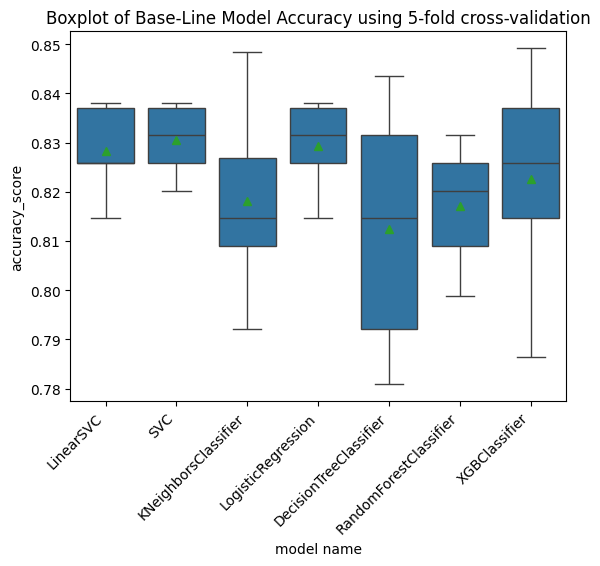

,Mean,Std
model name,,
SVC,0.830519,0.007542
LogisticRegression,0.829396,0.009598
LinearSVC,0.828272,0.009624
XGBClassifier,0.822641,0.023935
KNeighborsClassifier,0.818172,0.020966
RandomForestClassifier,0.817080,0.013135
DecisionTreeClassifier,0.812535,0.026187


In [77]:
from sklearn.model_selection import StratifiedKFold
def generate_baseline_results(models, x, y, metrics, cv=5, plot_results=False):
    kfold = StratifiedKFold(cv, shuffle = True, random_state = 42)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        score = cross_val_score(model, x, y, scoring = metrics, cv = kfold)
        for fold_idx, score in enumerate(score):
            entries.append((model_name, fold_idx, score))
    cv_df = pd.DataFrame(entries, columns=['model name', 'fold_id', 'accuracy_score'])
    
    if plot_results:
        sns.boxplot(x='model name', y='accuracy_score', data=cv_df, showmeans=True)
        plt.title("Boxplot of Base-Line Model Accuracy using 5-fold cross-validation")
        plt.xticks(rotation=45, ha='right')
        plt.show()

    mean = cv_df.groupby(['model name'])['accuracy_score'].mean()
    std = cv_df.groupby(['model name'])['accuracy_score'].std()

    ans = pd.concat([mean, std], axis = 1, ignore_index=True)
    ans.columns = ['Mean', 'Std']
    ans.sort_values(by=['Mean'], ascending=False, inplace=True)
    
    return ans
generate_baseline_results(models, X, y, metrics = 'accuracy', cv = 5, plot_results = True)

* Dựa theo kết quả baseline model có thể thấy SVC cho kết quả tốt nhất, ta sẽ thử nghiệm tiếp với Deep Learning 

In [78]:
X_deep_train = X_train
X_deep_val = X_val
y_deep_train = y_train
y_deep_val = y_val

In [79]:
X_deep_train = X_deep_train.astype('float32')
X_deep_val = X_deep_val.astype('float32')
y_deep_train = y_deep_train.astype('float32')
y_deep_val = y_deep_val.astype('float32')

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score


model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_deep_train, y_deep_train,
                    validation_data=(X_deep_val, y_deep_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1)


Epoch 1/50


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6070 - loss: 0.6619 - val_accuracy: 0.7263 - val_loss: 0.5664
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7445 - loss: 0.5603 - val_accuracy: 0.7821 - val_loss: 0.5141
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7772 - loss: 0.5008 - val_accuracy: 0.7765 - val_loss: 0.4843
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8033 - loss: 0.4573 - val_accuracy: 0.7933 - val_loss: 0.4702
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8335 - loss: 0.4300 - val_accuracy: 0.7989 - val_loss: 0.4601
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8385 - loss: 0.4134 - val_accuracy: 0.7877 - val_loss: 0.4572
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8214 - loss: 0.4437 - val_accuracy: 0.7933 - val_loss: 0.4489
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8081 - loss: 0.4456 - val_accuracy: 0.7877 - val_loss: 0.4475
Epo

In [81]:
y_pred_prob = model.predict(X_deep_val)
y_pred = (y_pred_prob > 0.5).astype("int32")
print("Test Accuracy:", accuracy_score(y_deep_val, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test Accuracy: 0.7988826815642458


* Đồ thị Accuracy và Loss của mô hình Deep Learning

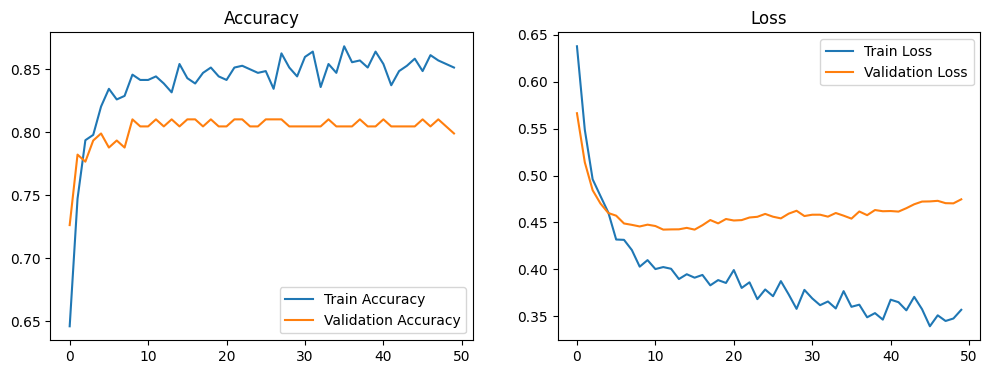

In [82]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()

## Hyperparameter Tuning

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Logistic Regression với GridSearch
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear'],
    'model__max_iter': [1000, 3000, 5000]
}

# Tạo pipeline gồm cả preprocessing + model
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LogisticRegression())
])

# GridSearch với pipeline
grid = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid.fit(X_raw, y)  # X_raw chứa cột string: Sex, Embarked, Title, ...

print("✅ Best params:", grid.best_params_)
print("✅ Best score:", grid.best_score_)


✅ Best params: {'model__C': 100, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
✅ Best score: 0.8316364321134895


* Lưu mô hình tốt nhất

In [84]:
import joblib

final_model = grid.best_estimator_
joblib.dump(final_model, "../models/logistic_final_titanic.pkl")
print("✅ Mô hình đã được lưu.")


✅ Mô hình đã được lưu.
